# Combining Models

Content:
- Base Classifier
    - Train a Least Squares classifier, perform a prediction on the samples, and compute the accuracy
    - Plot the decision boundary for least squares classifier
- Committees
    - Split the training data into M=9 equally sized, non-overlapping parts
    - Train M=9 Least Squares classifiers, one for each data split
    - Perform predictions on the whole dataset using a comitteee of classifiers and compute the accuracy
    - Plot the decision boundary for committee classifier
- Decision tree
    - Fit a DecisionTreeClassifier using scikit-learn, perform a prediction on the data, and compute the accuracy
    - Plot the decision boundary for the DecisionTreeClassifier
- AdaBoost
    - Create an AdaBoost classifier of DecisionTreeClassifiers using the scikit-learn library
    - Plot the decision boundary for the AdaBoostClassifier


In [1]:
# Dependencies
import numpy as np
import scipy
from sklearn.datasets import load_digits
from sklearn.decomposition import PCA 
import matplotlib.pyplot as plt 
import seaborn as sns; sns.set(); sns.set_palette('bright')
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import AdaBoostClassifier

In [2]:
# Some plotting functions, we'll be using later
def plot_scatter(data, target, alpha=0.5, legend=True):
    scatter = plt.scatter(data[:, 0], data[:, 1], c=target, edgecolor='none', alpha=alpha, cmap='rainbow')
    if legend:
        plt.legend(*scatter.legend_elements(), loc="upper right", title="Targets")
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    
def plot_mesh(X, pred_fn, n_class=2):
    plt_margin = 5
    x_min, x_max = min(X[:,0]) - plt_margin, max(X[:,0]) + plt_margin
    y_min, y_max = min(X[:,1]) - plt_margin, max(X[:,1]) + plt_margin
    h = 0.1  # step size in the mesh
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    Z = pred_fn(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    cs = plt.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))

# Dataset
We'll be working with a slightly modified version of the digits data.

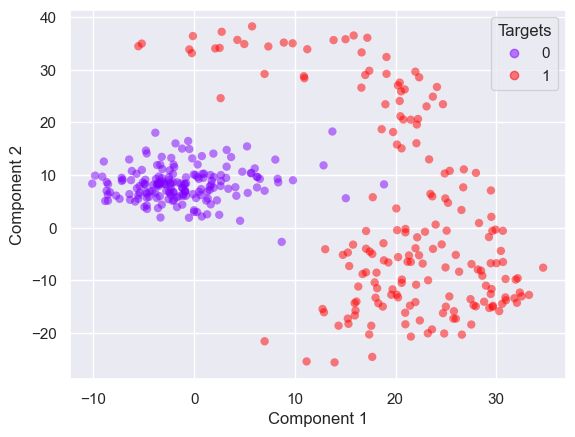

In [3]:
digits = load_digits(n_class=2)

# Get a 2D version of the data using PCA
pca = PCA(n_components=2)
t = digits.target
X = pca.fit_transform(digits.data)

# In order to get a non-linearly seperable case, 
# we'll modify the data a bit this time, 
# translating the '-1' class to the right and up
X = np.where(
    np.repeat(np.expand_dims(t == 1, axis=1), 2, axis=1), 
    X, 
    np.vstack([X[:,0]+20, X[:,1]+10]).T
)

N = len(t) # total number of samples

plot_scatter(X, t)

# 0) Base Classifier

## 0.1) Train a Least Squares classifier, perform a prediction on the samples, and compute the accuracy
Using our solution from the exercise "Week 7 - Linear classification" section 1.1 and 1.2. The accuracy is to be calculated in terms of the proportion of correct predictions compared to the number of predictions and should print a single float.

In [4]:
def linear_regression(X,t):
    X_tilde =  np.hstack((np.ones((X.shape[0], 1)), X))
    T = np.array([[0, 1] if target == 1 else [1, 0] for target in t])
    return np.linalg.pinv(X_tilde.T @ X_tilde) @ X_tilde.T @ T

def predict(W_tilde, X):
    X_tilde =  np.hstack((np.ones((X.shape[0], 1)), X))  # Add bias term to X
    ys = [W_tilde.T @ x_tilde[:, np.newaxis] for x_tilde in X_tilde]
    pred = np.array([np.argmax(y) for y in ys])
    return pred
    
W_lr = linear_regression(X,t)
W_lr

t_least_squares = predict(W_lr, X)
print(W_lr)
print(f"accuracy: {(t_least_squares == t).mean() * 100}")

[[ 0.87801476  0.12198524]
 [-0.0362166   0.0362166 ]
 [-0.00514282  0.00514282]]
accuracy: 94.72222222222221


## 0.2) Plot the decision boundary for least squares classifier

C:\Users\matti\AppData\Local\Temp\ipykernel_9044\3735908384.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cs = plt.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))


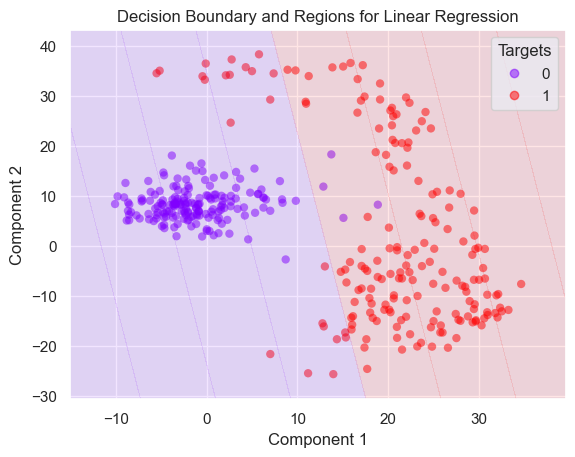

In [5]:
def predict_proba(W_tilde, X):
    X_tilde = np.hstack((np.ones((X.shape[0], 1)), X))
    ys = [W_tilde.T @ x_tilde[:, np.newaxis] for x_tilde in X_tilde]
    return np.array([y[1] for y in ys])

W_lr = linear_regression(X, t)
t_least_squares = predict(W_lr, X)

plot_scatter(X, t)
plot_mesh(X, lambda x: predict_proba(W_lr, x))
plt.title("Decision Boundary and Regions for Linear Regression")
plt.show()

# 1) Committees

## 1.1) Split the training data into M=9 equally sized, non-overlapping parts
We use the numpy.split() command.

In [6]:
M = 9

t_split = np.split(t, 9)
X_split = np.split(X, 9)

## 1.2) Train M=9 Least Squares classifiers, one for each (9) data split using the same method as in section 0.1
Looping over the training data containing of the X split and t split zipped together using the zip() command.

In [7]:
W_lr_list = [] 

for X_sub, t_sub in zip(X_split, t_split):
    X_sub = np.array(X_sub)
    t_sub = np.array(t_sub)
    W_lr_sub = linear_regression(X_sub, t_sub)
    
    W_lr_list.append(W_lr_sub)
    
    t_least_squares_sub = predict(W_lr_sub, X_sub)

## 1.3) Perform a prediction on the whole dataset using committee of classifiers (lecture 17 slide 4) and compute the accuracy 

In [8]:
def committee_predict(X, W_lr_list):
    predictions = [predict(W, X) for W in W_lr_list]
    
    averaged_predictions = np.mean(predictions, axis=0)
    
    final_prediction = np.round(averaged_predictions)
    
    return final_prediction

y_com = committee_predict(X, W_lr_list)

accuracy = np.mean(y_com == t) * 100
print(f"Committee accuracy: {accuracy:.2f}%")


Committee accuracy: 94.44%


## 1.4 Plot the decision boundary for committee classifier

C:\Users\matti\AppData\Local\Temp\ipykernel_9044\3735908384.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cs = plt.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))


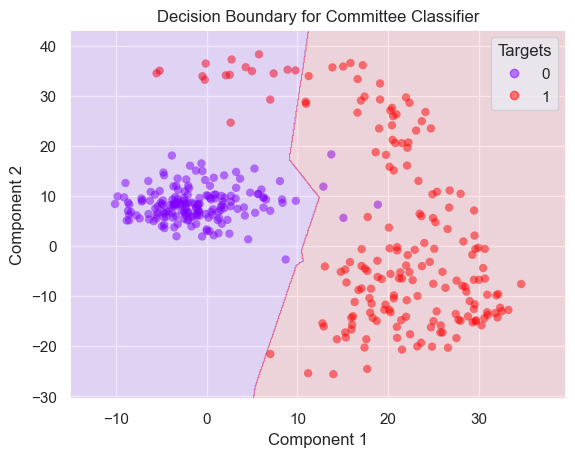

In [9]:
def committee_pred_fn(X):
    return committee_predict(X, W_lr_list)

plot_scatter(X, t)

plot_mesh(X, committee_pred_fn)

plt.title("Decision Boundary for Committee Classifier")
plt.show()

# 2) Tree

## 2.1) Fit a DecisionTreeClassifier imported from the `scikit-learn` library, perform a prediction on the data, and compute the accuracy
We use fit() and predict() methods of the DecisionTreeClassifier class in order to respectively train and predict from your classifier

In [10]:
clf = DecisionTreeClassifier(max_depth=3)
clf.fit(X, t)
adb_predictions = clf.predict(X)
adb_accuracy = (adb_predictions == t).mean() * 100
print(f"DecisionTreeClassifier accuracy: {adb_accuracy:.2f}%")

DecisionTreeClassifier accuracy: 98.89%


## 2.2) Plot the decision boundary for the DecisionTreeClassifier

C:\Users\matti\AppData\Local\Temp\ipykernel_9044\3735908384.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cs = plt.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))


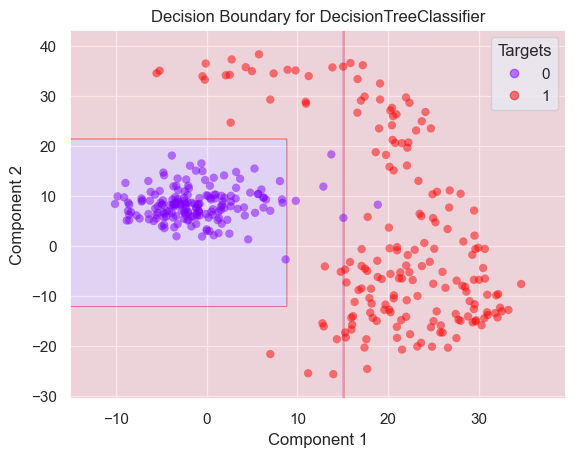

In [11]:
def dtc_predict_fn(data):
    return clf.predict(data)

plot_mesh(X, dtc_predict_fn)

plot_scatter(X, t)

plt.title("Decision Boundary for DecisionTreeClassifier")
plt.show()


# 3) AdaBoost

## 3.1) Create an AdaBoost classifier of DecisionTreeClassifiers using the `scikit-learn` library, and compute the accuracy
Useing a depth of 1 for the `DecisionTreeClassifier` and 7 estimators for the `AdaBoostClassifier` as well as the defaults for the other parameters

In [12]:
dtc = DecisionTreeClassifier(max_depth=1)
dtc.fit(X, t)


from sklearn.ensemble import AdaBoostClassifier

adb = AdaBoostClassifier(estimator=dtc, n_estimators=7)
adb.fit(X, t)

adb_predictions = adb.predict(X)

adb_accuracy = (adb_predictions == t).mean() * 100
print(f"Accuracy of AdaBoostClassifier: {adb_accuracy:.2f}%")


Accuracy of AdaBoostClassifier: 100.00%


## 3.2) Plot the decision boundary for the AdaBoostClassifier

C:\Users\matti\AppData\Local\Temp\ipykernel_9044\3735908384.py:17: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cs = plt.contourf(xx, yy, Z, alpha = 0.1, cmap=plt.cm.get_cmap('rainbow', n_class))


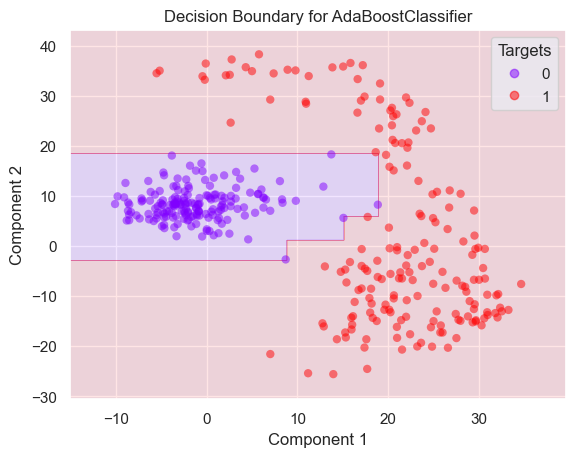

In [13]:
def adb_predict_fn(data):
    return adb.predict(data)

plot_mesh(X, adb_predict_fn)

plot_scatter(X, t)

plt.title("Decision Boundary for AdaBoostClassifier")
plt.show()